<a href="https://colab.research.google.com/github/sss20young/20190828_Image-AI/blob/master/Image_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# for image
import matplotlib.pyplot as plt
import numpy as np

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

0it [00:00, ?it/s]

170500096it [00:04, 41295318.09it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

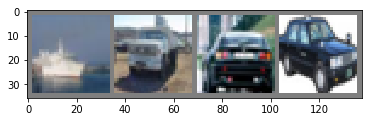

 ship truck   car   car


In [6]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
net = models.resnet18() # torchvision 에 이미 정의된 모델을 가져옵니다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
print('\n===> Training Start')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
if torch.cuda.device_count() > 1:
    print('\n===> Training on GPU!')
    net = nn.DataParallel(net)
net.cuda()


===> Training Start


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
epochs = 2 # dataset을 여러번 사용해 트레이닝을 시킵니다.

for epoch in range(epochs):
    print('\n===> epoch %d' % epoch)
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients                                        
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
 
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


===> epoch 0
[1,  2000] loss: 2.415
[1,  4000] loss: 2.100
[1,  6000] loss: 1.951
[1,  8000] loss: 1.885
[1, 10000] loss: 1.794
[1, 12000] loss: 1.729

===> epoch 1
[2,  2000] loss: 1.625
[2,  4000] loss: 1.546
[2,  6000] loss: 1.533
[2,  8000] loss: 1.502
[2, 10000] loss: 1.454
[2, 12000] loss: 1.391


In [10]:


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# 예측한 값 저장
predicted_list=[]
# 원래 값 (정답) 저장
labels_list=[]

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.cuda(), 1) # prediction
        c = (predicted == labels.cuda()).squeeze()
        predicted_list.append(predicted.tolist())
        labels_list.append(labels.tolist())
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 65 %
Accuracy of  bird : 34 %
Accuracy of   cat : 39 %
Accuracy of  deer : 41 %
Accuracy of   dog : 35 %
Accuracy of  frog : 64 %
Accuracy of horse : 62 %
Accuracy of  ship : 70 %
Accuracy of truck : 61 %


In [11]:
# 예측값과 정답 비교
print('예측값 ', predicted_list[123])
print('정답 (label'), labels_list[123]

예측값  [0, 1, 1, 8]
정답 (label


(None, [8, 1, 1, 8])